In [ ]:
print("Let's Get Started")

Let's Get Started


## Imports

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil


## Performance of RANSAC

In [9]:
def performance(M, mask, src_pts, dst_pts):
  # Calculate inlier ratio
  inliers = mask.ravel().sum()
  total_matches = len(mask)
  inlier_ratio = inliers / total_matches

  # Calculate reprojection error
  reprojection_errors = []
  for i in range(len(src_pts)):
      if mask[i]:  # Only consider inliers
          projected_point = cv2.perspectiveTransform(np.array([src_pts[i]]), M)
          error = np.linalg.norm(dst_pts[i] - projected_point)
          reprojection_errors.append(error)

  average_reprojection_error = np.mean(reprojection_errors)

  print(f"Inlier Ratio: {inlier_ratio:.2f}")
  print(f"Average Reprojection Error: {average_reprojection_error:.2f}")


## Display Function

In [ ]:
# Display function for Colab
def showplt(image, title=None, pltnative=False, custSize=(10, 10)):
    plt.figure(figsize=custSize)
    if pltnative:
        plt.imshow(image)
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if title:
        plt.title(title)
    plt.xticks([]), plt.yticks([])
    plt.show()

## Image Wrapping Functions

In [10]:
# Warp images based on the homography
def warpImages(img1, img2, H):
    rows1, cols1 = img1.shape[:2]
    rows2, cols2 = img2.shape[:2]

    list_of_points_1 = np.float32([[0, 0], [0, rows1], [cols1, rows1], [cols1, 0]]).reshape(-1, 1, 2)
    list_of_points_2 = cv2.perspectiveTransform(np.float32([[0, 0], [0, rows2], [cols2, rows2], [cols2, 0]]).reshape(-1, 1, 2), H)

    list_of_points = np.concatenate((list_of_points_1, list_of_points_2), axis=0)

    [x_min, y_min] = np.int32(list_of_points.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(list_of_points.max(axis=0).ravel() + 0.5)

    translation_dist = [-x_min, -y_min]
    H_translation = np.array([[1, 0, translation_dist[0]], [0, 1, translation_dist[1]], [0, 0, 1]])

    output_img = cv2.warpPerspective(img2, H_translation.dot(H), (x_max - x_min, y_max - y_min))
    output_img[translation_dist[1]:rows1 + translation_dist[1], translation_dist[0]:cols1 + translation_dist[0]] = img1

    return output_img

# Feature matching and stitching
def warp(img1, img2, min_match_count=10):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

    flann = cv2.FlannBasedMatcher(dict(algorithm=1, trees=5), dict(checks=50))
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)

    good_matches = [m1 for m1, m2 in matches if m1.distance < 0.7 * m2.distance]

    if len(good_matches) > min_match_count:
        src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        #Calling performance function
        performance(M, _, src_pts, dst_pts)
        #warpImage function
        result = warpImages(img2, img1, M)
        return result
    else:
        print(f"Not enough matches: {len(good_matches)}/{min_match_count}")
        return None

## Image Stitching Functions

In [7]:


#Stitch all the images present in a directory
def stitch_image_in_directory(input_directory, output_directory):
    filenames = sorted(os.listdir(input_directory))
    image_1 = cv2.imread(os.path.join(input_directory, filenames[0]))
    firstCollage = image_1

    for filename in filenames[1:]:
        image_2 = cv2.imread(os.path.join(input_directory, filename))
        firstCollage = warp(firstCollage, image_2)
        if firstCollage is None:
            print("Stitching failed.")
            return

    output_path = os.path.join(output_directory, "stitched_image.jpg")
    cv2.imwrite(output_path, firstCollage)
    showplt(firstCollage, title="Stitched Image")

#Stitch images batch wise
def stitch_images_in_batches(input_directory, output_directory, batch_size=5):
    # Get sorted list of image filenames
    filenames = sorted(os.listdir(input_directory))

    batch_index = 1
    for i in range(0, len(filenames), batch_size):
        batch_filenames = filenames[i:i+batch_size]

        # Load the first image of the batch as the initial base
        image_1 = cv2.imread(os.path.join(input_directory, batch_filenames[0]))
        firstCollage = image_1

        # Stitch images in the current batch
        for filename in batch_filenames[1:]:
            image_2 = cv2.imread(os.path.join(input_directory, filename))
            firstCollage = warp(firstCollage, image_2)
            if firstCollage is None:
                print("Stitching failed.")
                return

        # Save the stitched result for the current batch
        output_path = os.path.join(output_directory, f"stitched_batch_{batch_index}.jpg")
        cv2.imwrite(output_path, firstCollage)
        showplt(firstCollage, title=f"Stitched Batch {batch_index}")

        batch_index += 1




## Image Loading

Inlier Ratio: 0.74
Average Reprojection Error: 1.28
Inlier Ratio: 0.66
Average Reprojection Error: 1.12
Inlier Ratio: 0.72
Average Reprojection Error: 1.31
Inlier Ratio: 0.71
Average Reprojection Error: 1.44


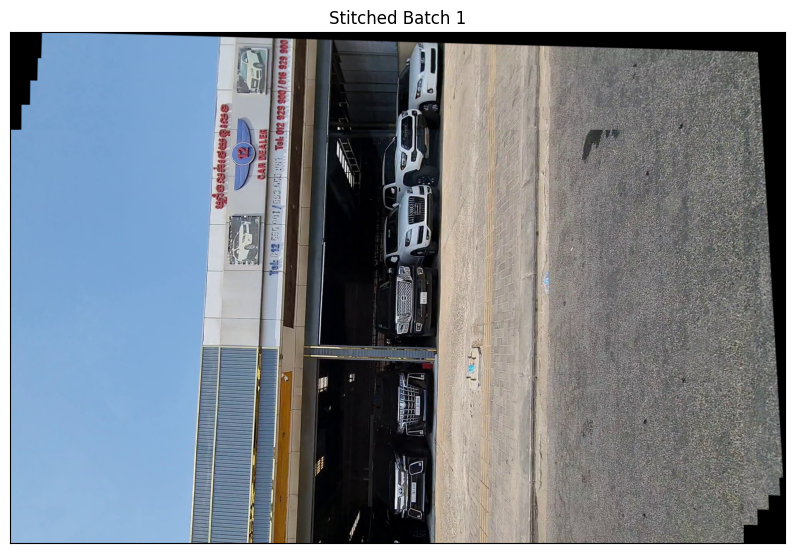

Inlier Ratio: 0.62
Average Reprojection Error: 1.08
Inlier Ratio: 0.57
Average Reprojection Error: 1.18
Inlier Ratio: 0.52
Average Reprojection Error: 1.16
Inlier Ratio: 0.60
Average Reprojection Error: 1.47


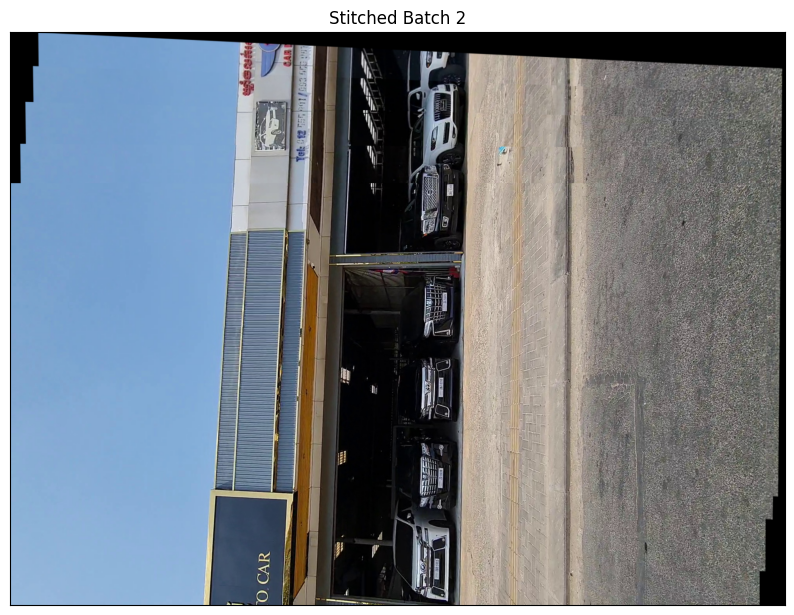

Inlier Ratio: 0.61
Average Reprojection Error: 1.32
Inlier Ratio: 0.65
Average Reprojection Error: 1.56
Inlier Ratio: 0.56
Average Reprojection Error: 1.45
Inlier Ratio: 0.52
Average Reprojection Error: 1.59


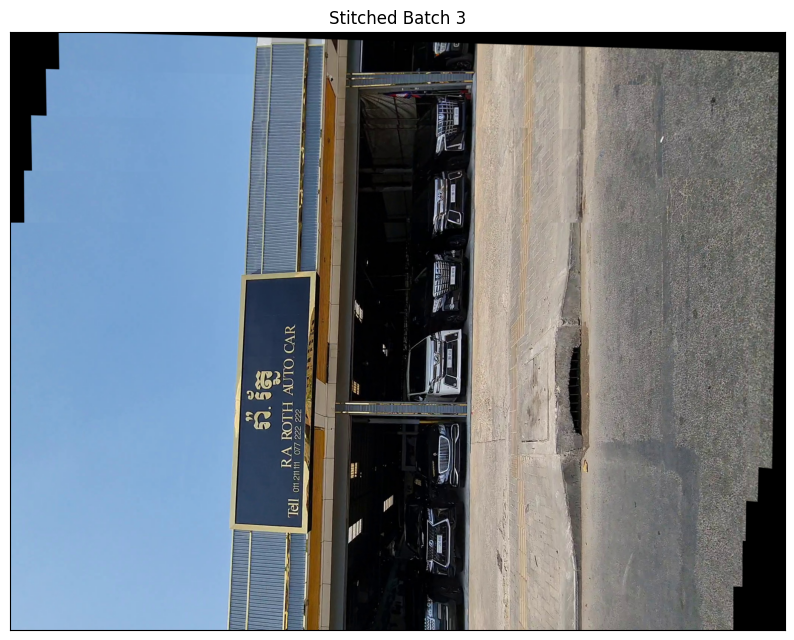

Inlier Ratio: 0.51
Average Reprojection Error: 1.48


KeyboardInterrupt: 

In [12]:
# Example of usage in Colab
input_directory = '/content/drive/MyDrive/images/original'  # Change to your image directory in Colab
output_directory = '/content/output_images'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# stitch_image_in_directory(input_directory, output_directory)
stitch_images_in_batches(input_directory, output_directory)